In [ ]:
#importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import random
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
#importing the training and validating data
filenames = os.listdir('/content/drive/MyDrive/UTD/Colab/dog-breed-identification/train')
filenames.sort()



In [ ]:
#importing labels for validation
labels = pd.read_csv('../content/drive/MyDrive/UTD/Colab/dog-breed-identification/labels.csv')
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

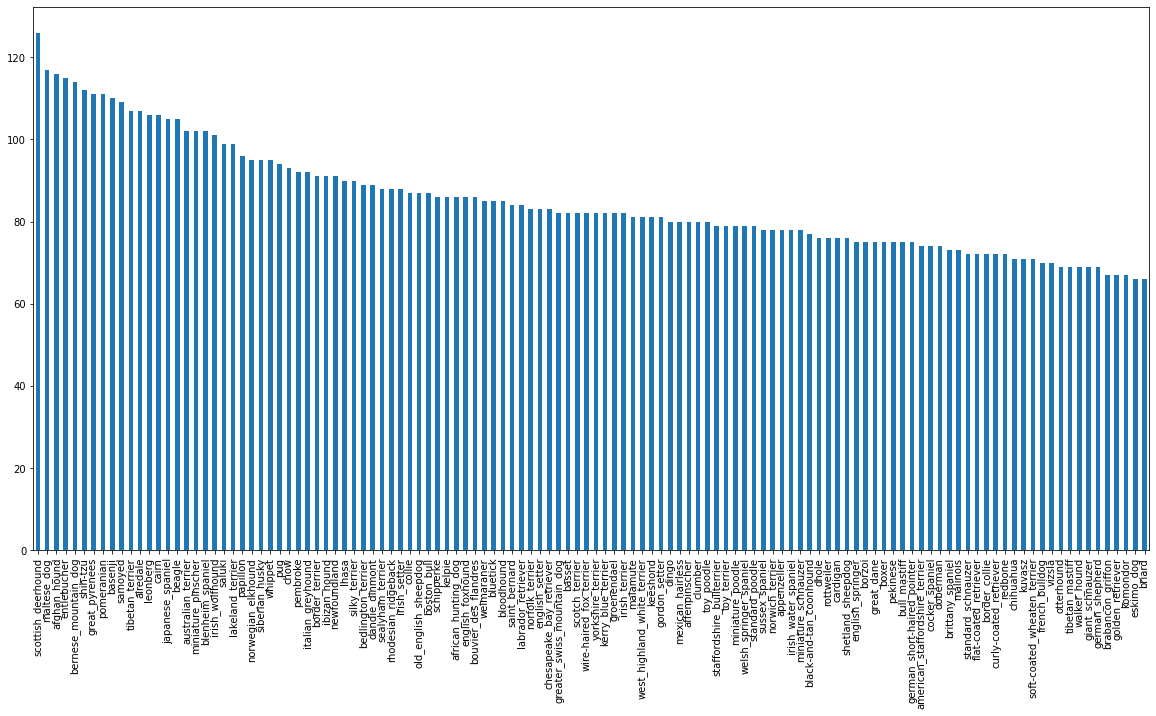

In [ ]:
#graph of unique labels
labels["breed"].value_counts().plot.bar(figsize=(20, 10));

In [ ]:
#creating a data frame with 2 columns, the file name and its label
df = pd.DataFrame({'filenames': filenames,'breeds': labels['breed']})
df.head()

filenames            breeds
0  000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
2  001cdf01b096e06d78e9e5112d419397.jpg          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever

In [ ]:
#split the data into train and validation
train_df,valid_df = train_test_split(df,test_size = 0.2,random_state = 101)

In [ ]:
train_df.shape,valid_df.shape

((8177, 2), (2045, 2))

In [ ]:
#Generating more data for more efficient training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)


In [ ]:
train_data = train_datagen.flow_from_dataframe( 
    train_df,
    "/content/drive/MyDrive/UTD/Colab/dog-breed-identification/train/", 
    x_col='filenames',
    y_col='breeds',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 8177 validated image filenames belonging to 120 classes.


In [ ]:
valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_data = valid_datagen.flow_from_dataframe(valid_df,
                                             "/content/drive/MyDrive/UTD/Colab/dog-breed-identification/train//",
                                             x_col = 'filenames',
                                             y_col = 'breeds',
                                             target_size = (224,224),
                                             class_mode = 'categorical',
                                             batch_size = 32)

Found 2045 validated image filenames belonging to 120 classes.


In [ ]:
#input, output shape and the Mobilenet V2 model link
INPUT_SHAPE = [None, 224, 224, 3] 
OUTPUT_SHAPE = 120 
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [ ]:
#function for creating the model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with MobileNet V2 at:", MODEL_URL)

  
    model = tf.keras.Sequential([                        
       hub.KerasLayer(MODEL_URL), 
       tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax")])
    model.compile(
       loss=tf.keras.losses.CategoricalCrossentropy(), 
       optimizer=tf.keras.optimizers.Adam(), 
       metrics=["accuracy"])

 
    model.build(INPUT_SHAPE) 
  
    return model

In [ ]:
#creating model
model = create_model()
model.summary()

Building model with MobileNet V2 at: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [ ]:
#Early stopping to stop training when it is not improving
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3) 
#function to train the model
def train_model():
    model = create_model()
    model.fit(x=train_data,
            epochs=10,
            validation_data=valid_data,
            validation_freq=1, 
            callbacks=early_stopping)
    return model
  

In [ ]:
#train the model
model = train_model()

Building model with MobileNet V2 at: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/10
256/256 [==============================] - 2104s 8s/step - loss: 1.8622 - accuracy: 0.5567 - val_loss: 0.8561 - val_accuracy: 0.7545
Epoch 2/10
256/256 [==============================] - 133s 521ms/step - loss: 0.7429 - accuracy: 0.7819 - val_loss: 0.7886 - val_accuracy: 0.7633
Epoch 3/10
256/256 [==============================] - 132s 514ms/step - loss: 0.5820 - accuracy: 0.8223 - val_loss: 0.8096 - val_accuracy: 0.7633
Epoch 4/10
256/256 [==============================] - 129s 504ms/step - loss: 0.4818 - accuracy: 0.8503 - val_loss: 0.7973 - val_accuracy: 0.7697
Epoch 5/10
256/256 [==============================] - 129s 502ms/step - loss: 0.4071 - accuracy: 0.8710 - val_loss: 0.8400 - val_accuracy: 0.7682
Epoch 6/10
256/256 [==============================] - 129s 505ms/step - loss: 0.3571 - accuracy: 0.8852 - val_loss: 0.8394 - val_accuracy: 0.7672
Epoch 7/10
256/25

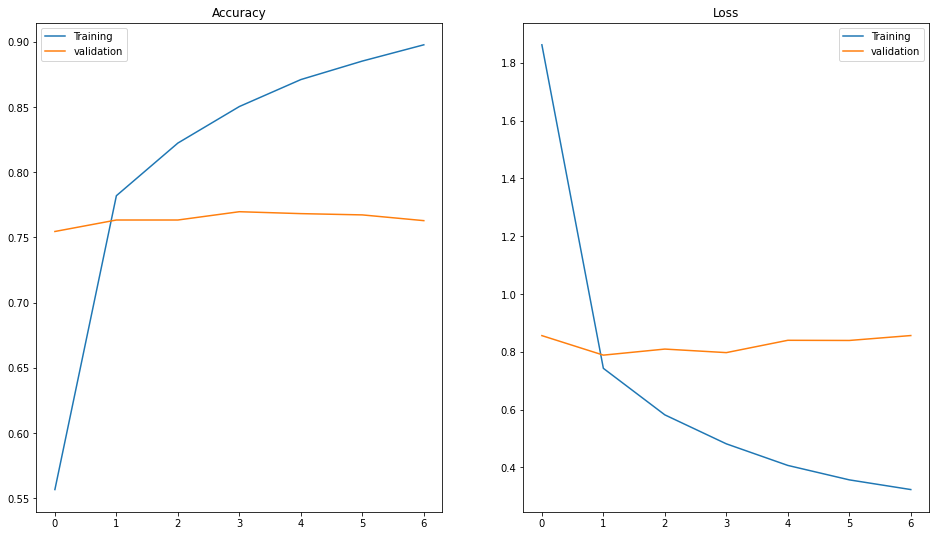

In [ ]:
plt.figure(figsize=(16,9))

plt.subplot(1,2,1)
plt.plot(model.history.epoch,model.history.history['accuracy'],label = 'Training')
plt.plot(model.history.epoch,model.history.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.history.epoch,model.history.history['loss'],label = 'Training')
plt.plot(model.history.epoch,model.history.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

In [294]:
#predicting the validation data using the model
preds = model.predict(valid_data,verbose=1)

64/64 [==============================] - 11s 165ms/step


In [295]:
#preparing the label
label_match = df.breeds.unique()
label_match = pd.DataFrame (label_match)
label_match['index'] = label_match.index
label_match

0  index
0             boston_bull      0
1                   dingo      1
2                pekinese      2
3                bluetick      3
4        golden_retriever      4
..                    ...    ...
115  bouvier_des_flandres    115
116       tibetan_mastiff    116
117      english_springer    117
118        cocker_spaniel    118
119            rottweiler    119

[120 rows x 2 columns]

In [296]:
#getting the result into a dataframe
pred  = [np.argmax(i) for i in preds]
pred_result = pd.DataFrame(pred)
pred_result["breed"] = "none"
for i in range(len(pred_result)):
  pred_result.iat[i,1] = label_match.iat[pred_result.iat[i,0],0]

In [297]:
#outputing images for comparision
from keras.preprocessing import image
image_path = '/content/drive/MyDrive/UTD/Colab/dog-breed-identification/train/'
def check_images(img):
    #get random number for random section of images
    random_num= random.randint(0, len(valid_df)-1)
    plt.figure(figsize=[30,20])
    for i in range(25):
        plt.subplot(5,5,i+1)
        image = plt.imread(image_path+df.iat[i,0])
        plt.imshow(image)
        plt.title('True label: '+df.iat[i,1]+'\n'+ 'Predicted label: '+pred_result.iat[i,1])
        plt.axis('off')

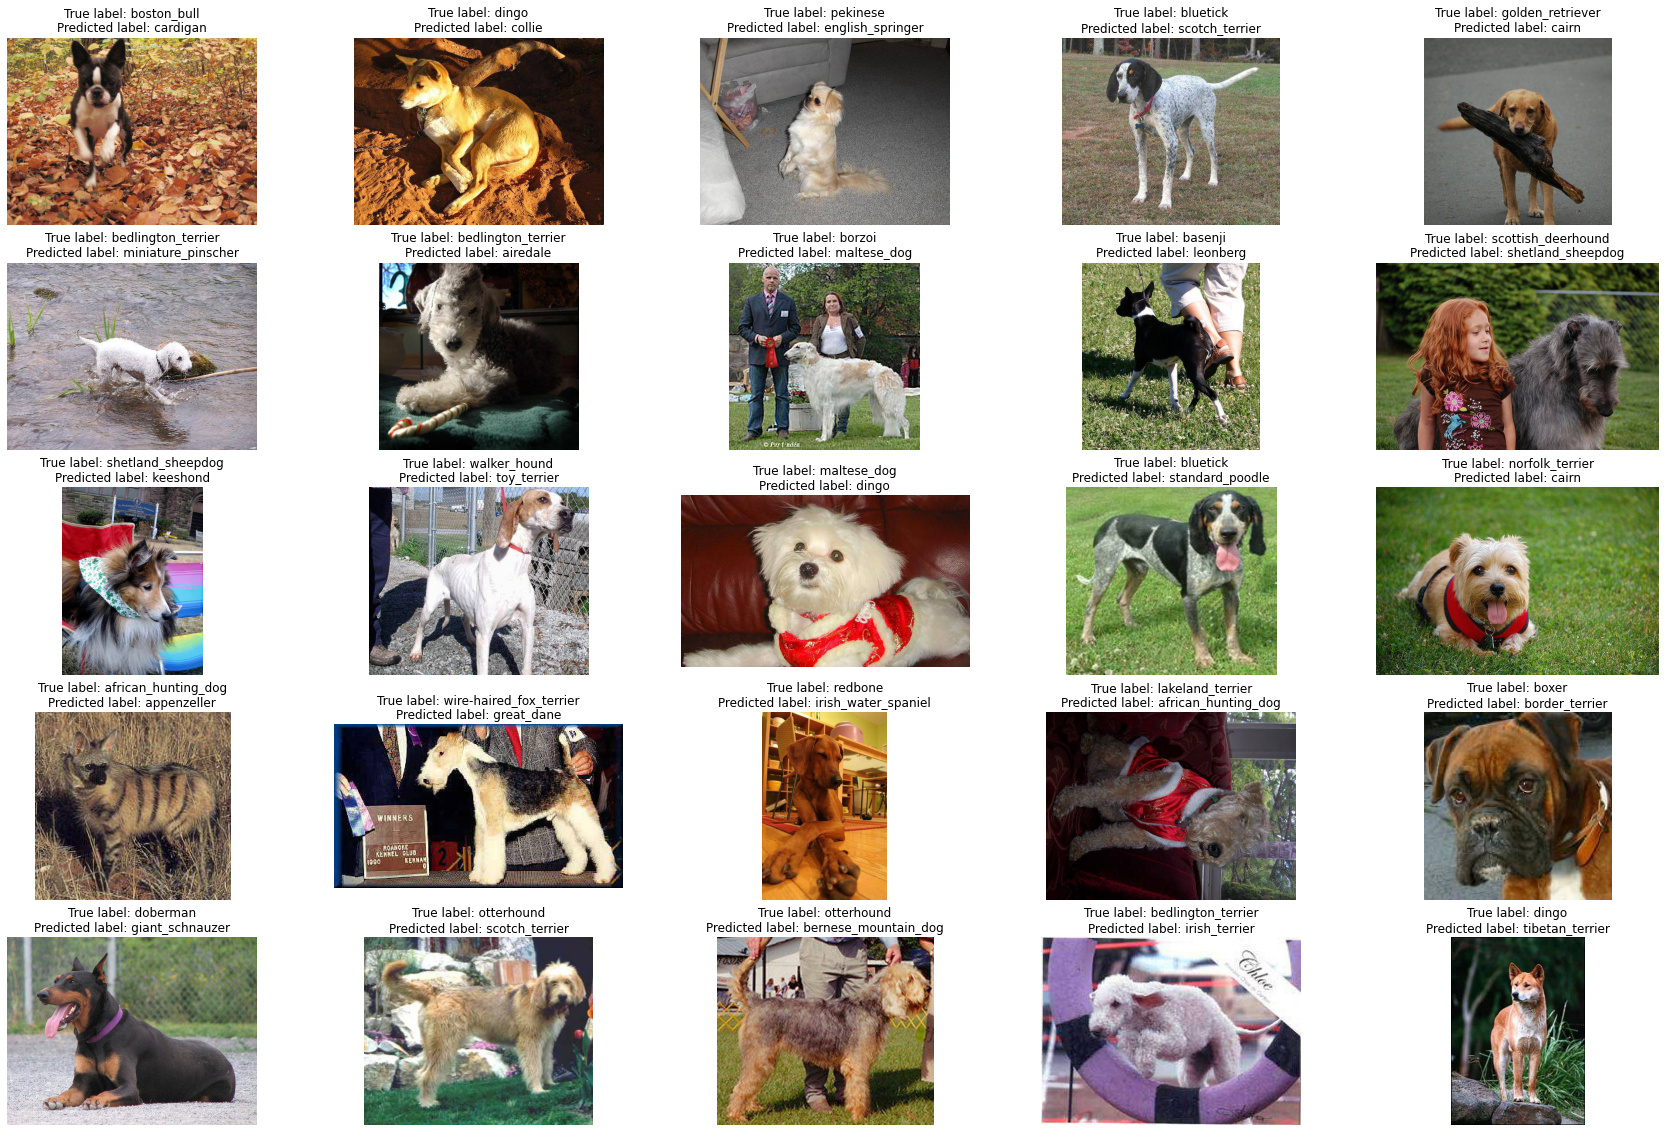

In [298]:
X = next(valid_data)
check_images(X)


In [299]:
#SECOND RUN

In [300]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)


In [301]:
train_data = train_datagen.flow_from_dataframe( 
    train_df,
    "/content/drive/MyDrive/UTD/Colab/dog-breed-identification/train/", 
    x_col='filenames',
    y_col='breeds',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 8177 validated image filenames belonging to 120 classes.


In [302]:
valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_data = valid_datagen.flow_from_dataframe(valid_df,
                                             "/content/drive/MyDrive/UTD/Colab/dog-breed-identification/train//",
                                             x_col = 'filenames',
                                             y_col = 'breeds',
                                             target_size = (224,224),
                                             class_mode = 'categorical',
                                             batch_size = 32)

Found 2045 validated image filenames belonging to 120 classes.


In [303]:
#input, output shape and the Mobilenet V2 model link
INPUT_SHAPE = [None, 224, 224, 3] 
OUTPUT_SHAPE = 120 
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [312]:
#function for creating the model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with MobileNet V2 at:", MODEL_URL)

  
    model = tf.keras.Sequential([                        
       hub.KerasLayer(MODEL_URL), 
       tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax")])
    model.compile(
       loss=tf.keras.losses.CategoricalCrossentropy(), 
       optimizer=tf.keras.optimizers.Adam(), 
       metrics=["accuracy"])

 
    model.build(INPUT_SHAPE) 
  
    return model

In [313]:
#creating model
model = create_model()
model.summary()

Building model with MobileNet V2 at: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_6 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [314]:
#Early stopping to stop training when it is not improving
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3) 
#function to train the model
def train_model():
    model = create_model()
    model.fit(x=train_data,
            epochs=10,
            validation_data=valid_data,
            validation_freq=1, 
            callbacks=early_stopping)
    return model
  

In [315]:
#train the model
model = train_model()

Building model with MobileNet V2 at: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/10
256/256 [==============================] - 139s 526ms/step - loss: 1.8789 - accuracy: 0.5507 - val_loss: 0.8636 - val_accuracy: 0.7521
Epoch 2/10
256/256 [==============================] - 136s 530ms/step - loss: 0.7700 - accuracy: 0.7702 - val_loss: 0.7821 - val_accuracy: 0.7648
Epoch 3/10
256/256 [==============================] - 133s 518ms/step - loss: 0.6085 - accuracy: 0.8136 - val_loss: 0.7773 - val_accuracy: 0.7682
Epoch 4/10
256/256 [==============================] - 137s 534ms/step - loss: 0.4998 - accuracy: 0.8447 - val_loss: 0.7984 - val_accuracy: 0.7653
Epoch 5/10
256/256 [==============================] - 133s 521ms/step - loss: 0.4386 - accuracy: 0.8586 - val_loss: 0.8288 - val_accuracy: 0.7628
Epoch 6/10
256/256 [==============================] - 135s 528ms/step - loss: 0.3949 - accuracy: 0.8715 - val_loss: 0.8550 - val_accuracy: 0.7716
Epoch 7/10
256/

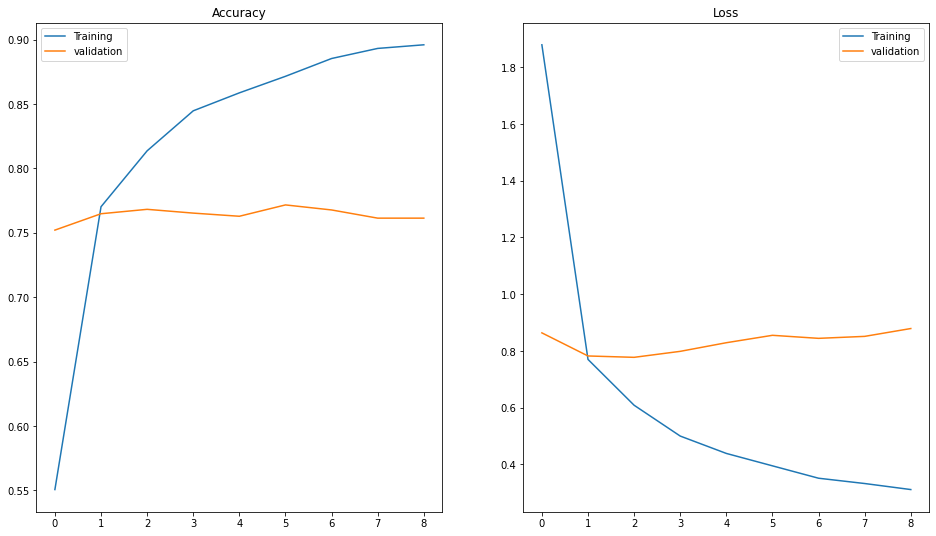

In [316]:
plt.figure(figsize=(16,9))

plt.subplot(1,2,1)
plt.plot(model.history.epoch,model.history.history['accuracy'],label = 'Training')
plt.plot(model.history.epoch,model.history.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.history.epoch,model.history.history['loss'],label = 'Training')
plt.plot(model.history.epoch,model.history.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

In [322]:
#predicting the validation data using the model
preds = model.predict(valid_data,verbose=1)

64/64 [==============================] - 10s 162ms/step


In [323]:
#preparing the label
label_match = df.breeds.unique()
label_match = pd.DataFrame (label_match)
label_match['index'] = label_match.index
label_match

0  index
0             boston_bull      0
1                   dingo      1
2                pekinese      2
3                bluetick      3
4        golden_retriever      4
..                    ...    ...
115  bouvier_des_flandres    115
116       tibetan_mastiff    116
117      english_springer    117
118        cocker_spaniel    118
119            rottweiler    119

[120 rows x 2 columns]

In [324]:
#getting the result into a dataframe
pred  = [np.argmax(i) for i in preds]
pred_result = pd.DataFrame(pred)
pred_result["breed"] = "none"
for i in range(len(pred_result)):
  pred_result.iat[i,1] = label_match.iat[pred_result.iat[i,0],0]

In [327]:
#outputing images for comparision
from keras.preprocessing import image
image_path = '/content/drive/MyDrive/UTD/Colab/dog-breed-identification/train/'
def check_images(img):
    #get random number for random section of images
    random_num= random.randint(0, len(valid_df)-1)
    plt.figure(figsize=[20,15])
    for i in range(25):
        plt.subplot(5,5,i+1)
        image = plt.imread(image_path+df.iat[i,0])
        plt.imshow(image)
        plt.title('True label: '+df.iat[i,1]+'\n'+ 'Predicted label: '+pred_result.iat[i,1])
        plt.axis('off')

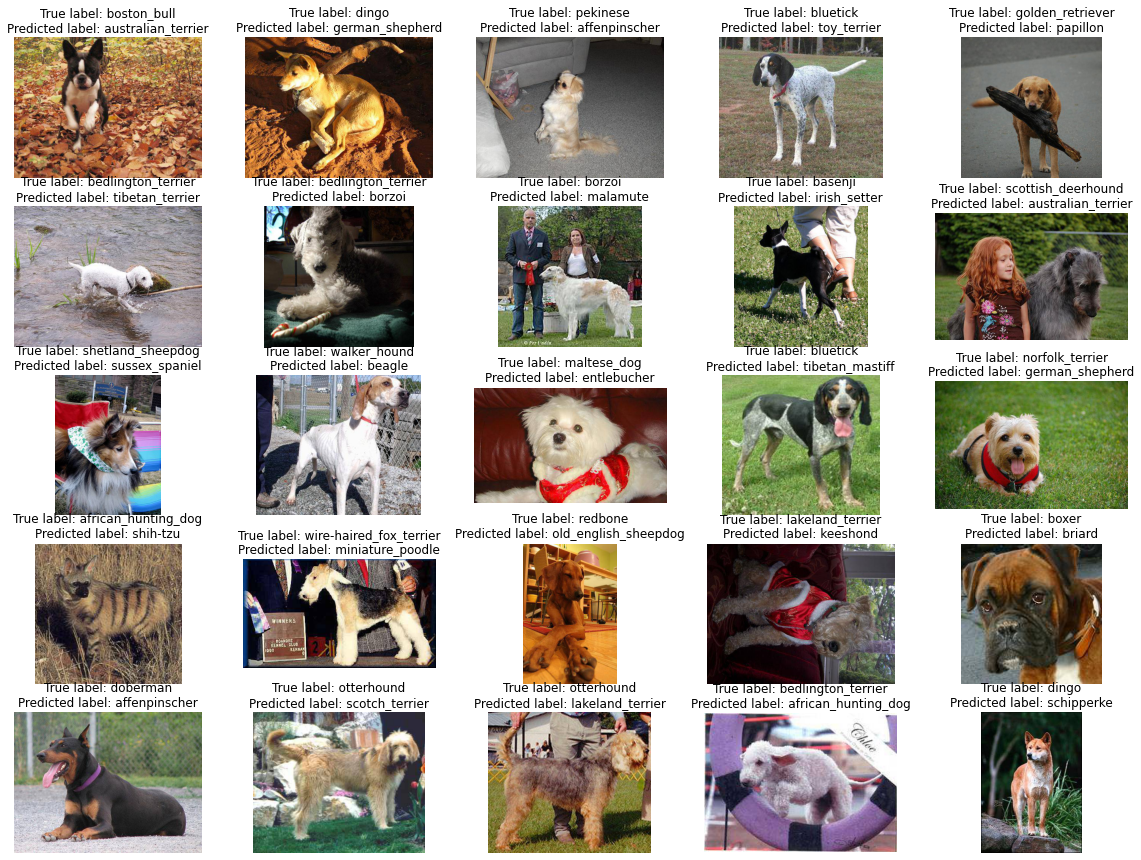

In [328]:
X = next(valid_data)
check_images(X)


In [329]:
#THIRD RUN

In [330]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    rescale=1./255,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    width_shift_range=0.15,
    height_shift_range=0.15
)


In [331]:
train_data = train_datagen.flow_from_dataframe( 
    train_df,
    "/content/drive/MyDrive/UTD/Colab/dog-breed-identification/train/", 
    x_col='filenames',
    y_col='breeds',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16
)

Found 8177 validated image filenames belonging to 120 classes.


In [332]:
valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_data = valid_datagen.flow_from_dataframe(valid_df,
                                             "/content/drive/MyDrive/UTD/Colab/dog-breed-identification/train//",
                                             x_col = 'filenames',
                                             y_col = 'breeds',
                                             target_size = (224,224),
                                             class_mode = 'categorical',
                                             batch_size = 16)

Found 2045 validated image filenames belonging to 120 classes.


In [333]:
#input, output shape and the Mobilenet V2 model link
INPUT_SHAPE = [None, 224, 224, 3] 
OUTPUT_SHAPE = 120 
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_075_224/classification/5"

In [334]:
#function for creating the model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with MobileNet V2 at:", MODEL_URL)

  
    model = tf.keras.Sequential([                        
       hub.KerasLayer(MODEL_URL), 
       tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax")])
    model.compile(
       loss=tf.keras.losses.CategoricalCrossentropy(), 
       optimizer=tf.keras.optimizers.Adam(), 
       metrics=["accuracy"])

 
    model.build(INPUT_SHAPE) 
  
    return model

In [335]:
#creating model
model = create_model()
model.summary()

Building model with MobileNet V2 at: https://tfhub.dev/google/imagenet/mobilenet_v2_075_224/classification/5
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_8 (KerasLayer)   (None, 1001)              2664345   
_________________________________________________________________
dense_8 (Dense)              (None, 120)               120240    
Total params: 2,784,585
Trainable params: 120,240
Non-trainable params: 2,664,345
_________________________________________________________________


In [336]:
#Early stopping to stop training when it is not improving
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3) 
#function to train the model
def train_model():
    model = create_model()
    model.fit(x=train_data,
            epochs=15,
            validation_data=valid_data,
            validation_freq=1, 
            callbacks=early_stopping)
    return model
  

In [337]:
#train the model
model = train_model()

Building model with MobileNet V2 at: https://tfhub.dev/google/imagenet/mobilenet_v2_075_224/classification/5
Epoch 1/15
512/512 [==============================] - 146s 277ms/step - loss: 2.0487 - accuracy: 0.5001 - val_loss: 1.0826 - val_accuracy: 0.6910
Epoch 2/15
512/512 [==============================] - 140s 274ms/step - loss: 1.1045 - accuracy: 0.6877 - val_loss: 1.0975 - val_accuracy: 0.6954
Epoch 3/15
512/512 [==============================] - 140s 273ms/step - loss: 0.9003 - accuracy: 0.7404 - val_loss: 1.1254 - val_accuracy: 0.7046
Epoch 4/15
512/512 [==============================] - 140s 273ms/step - loss: 0.8259 - accuracy: 0.7586 - val_loss: 1.1753 - val_accuracy: 0.6998
Epoch 5/15
512/512 [==============================] - 139s 272ms/step - loss: 0.7333 - accuracy: 0.7793 - val_loss: 1.2502 - val_accuracy: 0.6880
Epoch 6/15
512/512 [==============================] - 140s 273ms/step - loss: 0.7054 - accuracy: 0.7895 - val_loss: 1.2691 - val_accuracy: 0.6910


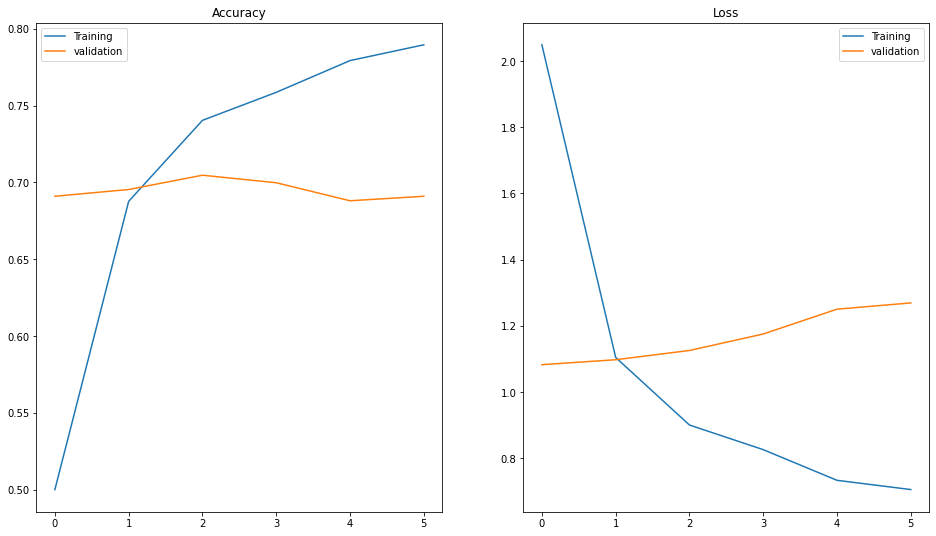

In [338]:
plt.figure(figsize=(16,9))

plt.subplot(1,2,1)
plt.plot(model.history.epoch,model.history.history['accuracy'],label = 'Training')
plt.plot(model.history.epoch,model.history.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.history.epoch,model.history.history['loss'],label = 'Training')
plt.plot(model.history.epoch,model.history.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

In [339]:
#predicting the validation data using the model
preds = model.predict(valid_data,verbose=1)

128/128 [==============================] - 12s 87ms/step


In [340]:
#preparing the label
label_match = df.breeds.unique()
label_match = pd.DataFrame (label_match)
label_match['index'] = label_match.index
label_match

0  index
0             boston_bull      0
1                   dingo      1
2                pekinese      2
3                bluetick      3
4        golden_retriever      4
..                    ...    ...
115  bouvier_des_flandres    115
116       tibetan_mastiff    116
117      english_springer    117
118        cocker_spaniel    118
119            rottweiler    119

[120 rows x 2 columns]

In [341]:
#getting the result into a dataframe
pred  = [np.argmax(i) for i in preds]
pred_result = pd.DataFrame(pred)
pred_result["breed"] = "none"
for i in range(len(pred_result)):
  pred_result.iat[i,1] = label_match.iat[pred_result.iat[i,0],0]

In [342]:
#outputing images for comparision
from keras.preprocessing import image
image_path = '/content/drive/MyDrive/UTD/Colab/dog-breed-identification/train/'
def check_images(img):
    #get random number for random section of images
    random_num= random.randint(0, len(valid_df)-1)
    plt.figure(figsize=[20,15])
    for i in range(25):
        plt.subplot(5,5,i+1)
        image = plt.imread(image_path+df.iat[i,0])
        plt.imshow(image)
        plt.title('True label: '+df.iat[i,1]+'\n'+ 'Predicted label: '+pred_result.iat[i,1])
        plt.axis('off')

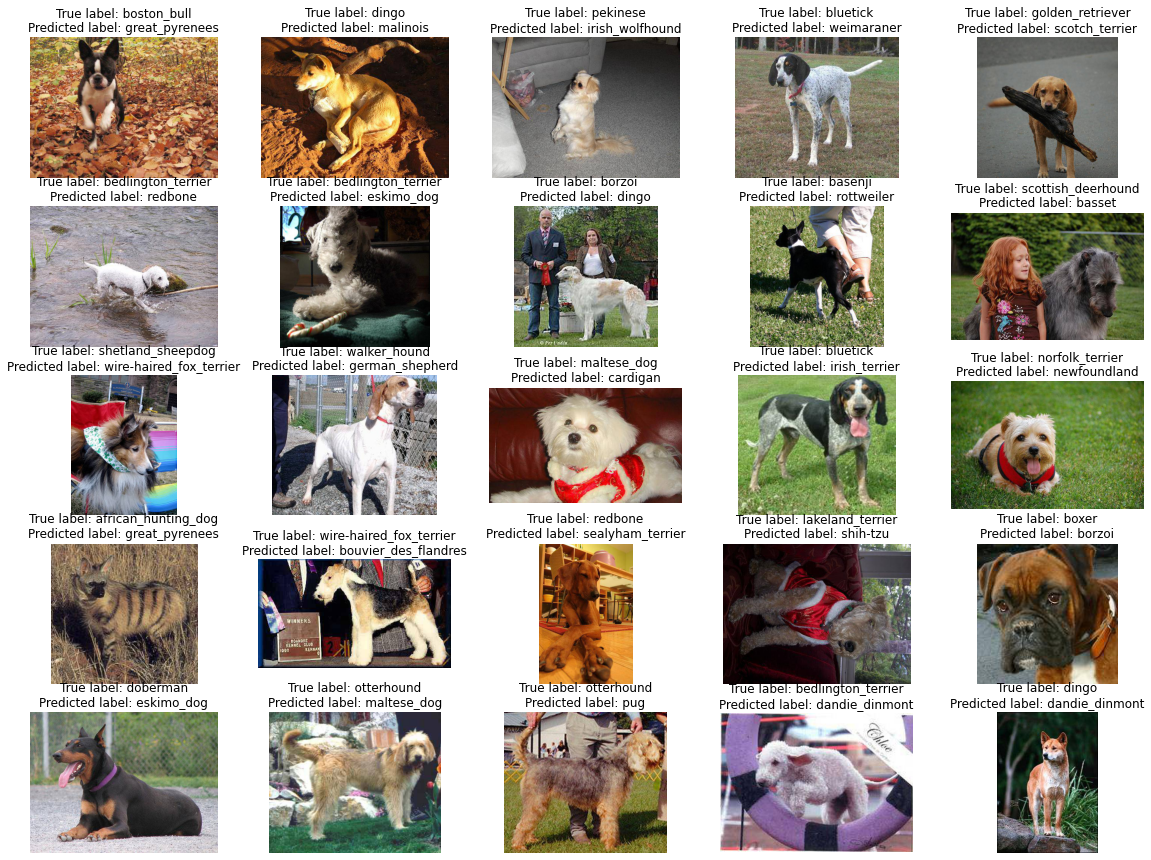

In [343]:
X = next(valid_data)
check_images(X)
